# Estimators

In [1]:
# import library
import pandas as pd
import numpy as np

# Model
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit,train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Evaluation
from sklearn.metrics import mean_squared_error
from mlens.metrics import make_scorer
from mlens.model_selection import Evaluator
from scipy.stats import uniform, randint

# Ensemble
from mlens.ensemble import SuperLearner

[MLENS] backend: threading


In [2]:
def calculable_features(df):
    result = []
    for col in df.columns:    
        if df[col].dtypes != object:
            result.append(col)
    return result

In [3]:
def cross_validation_with_selected_features(features, model):
    # generate train/test with selected features
    test_ids, y_train, x_train, x_test = generate_train_test_data(features, df_all)    
    # cross validation
    cv = ShuffleSplit(test_size=0.3, random_state=0)
    test_score = np.sqrt(-cross_val_score(model, x_train, y_train, cv=cv, scoring='neg_mean_squared_error'))
    return test_score

In [4]:
# Ranked features are identical[?]
def rank_features(features, model):
    '''
    features: all numeric features
    model: model
    '''
    result = []
    test_ids, y_train, x_train, x_test = generate_train_test_data(features, df_all)
    feature_importance = list(model.fit(x_train, y_train).feature_importances_)
    feature_feature_importance = pd.DataFrame({'feature': features[3:], 'feature_importance':feature_importance})
    features = feature_feature_importance.sort_values('feature_importance', ascending=False)
    
    return features

In [5]:
# cr.liuchang
def generate_train_test_data(features, df):
    '''
    Generate train/test data based on selected features.
    '''
    df_sub = df[features]
    # Seperate train and test data
    df_test = df_sub.loc[pd.isnull(df_sub['relevance'])]
    df_train = df_sub.loc[pd.notnull(df_sub['relevance'])]
    # Record test ids
    test_ids = df_test['id']
    # Get training label: relevance
    y_train = df_train['relevance'].values
    # Delete id and label
    X_train = df_train.drop(['id', 'relevance', 'product_uid'], axis=1).values
    X_test = df_test.drop(['id', 'relevance', 'product_uid'], axis = 1).values
    
    return test_ids, y_train, X_train, X_test

In [6]:
def num_of_features_cv_plot(model, feature_len, input_features):
    '''
    model: base learners
    feature_len: 
    '''
    test_scores = []
    num_of_features = list(range(2, feature_len + 1))
    for n in range(2, feature_len + 1):
        features = input_features[:n]
        features.extend(['id', 'relevance', 'product_uid'])    
        test_score = cross_validation_with_selected_features(features, model)
        test_scores.append(np.mean(test_score))
    
    %matplotlib inline
    plt.plot(num_of_features, test_scores)
    plt.title("Number of Features vs CV Error")

In [7]:
def generate_feature_importances_dataframes(base_learners):
    features_importances = pd.DataFrame()
    for model_name, model in base_learners:
        dataframe = rank_features(numeric_features, model)
        # reset index
        dataframe = dataframe.reset_index(drop=True)
        col_feature = 'feature_' + model_name
        col_feature_importance = 'importances_' + model_name
        features_importances[col_feature] = dataframe['feature']
        features_importances[col_feature_importance] = dataframe['feature_importance']        
    return features_importances

In [8]:
def gridSearch_tuning_estimators(estimators, params, X_train, y_train):
    for model_name, model in estimators:
        tuned = GridSearchCV(estimator=model, param_grid=params,cv=5)
        tuned.fit(X_train, y_train) # no attribute 'feature_importances_'
        model.set_params(**tuned.best_params_)

# Modeling

In most kaggle competitions, as the goal is to rank as high as possible in the leaderboard, the interpretability of a model is not that important. Many kaggle winners are using rather complicated techniques to get better scores. Esembling/Stacking is one of the most popular techniques. The idea is that by combining information from multiple predictive models, it is likely that the new model will outperform each of the individual models due its smoothing nature and ability to highlight each base model where it performs best and discredit each base model where it performs poorly. 

We use a 2-layer stacking model. The first layer consists of base learners, including random forest, gradient boosted tree, and xgboost. The second layer (meta learner) is linear regression.

In [9]:
# import processed data
SEED=0
df_all = pd.read_csv('data_with_features/df_all_with_62_features.csv', encoding="ISO-8859-1")

/Users/justinehe/Apps/Anaconda3/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
df_all = df_all[:100]

In [ ]:
df_all.dtypes

In [11]:
numeric_features = calculable_features(df_all)
test_ids, y_train, X_train, X_test = generate_train_test_data(numeric_features, df_all)

### 1. Feature Selection
The `sklean` library provides a very useful attributes `feature_importances_` after fitting a model. We use this attributes to rank features and select a heuristic number of features based on cross validation error. We use the following models for feature selections, which is also the base learners of stacking. 

#### 1.1 Parameter tuning

In [12]:
# models
rf = RandomForestRegressor(random_state=SEED)
gbt = GradientBoostingRegressor(random_state=SEED)
xgb = XGBRegressor(random_state=SEED)

base_learners = [
    ('rf', rf), ('gbt', gbt), ('xgb', xgb)
]

In [13]:
params = {
    'random_state': [0],
    'n_estimators':range(10, 20),
    'max_depth':range(3, 10)
}

In [14]:
# Tuning base learners
gridSearch_tuning_estimators(base_learners, params, X_train, y_train)

#### 1.2 Rank features
After ranking, we observed that the first 22 features have most influential among all features.

In [15]:
feature_importances = generate_feature_importances_dataframes(base_learners)

In [16]:
feature_importances

,feature_rf,importances_rf,feature_gbt,importances_gbt,feature_xgb,importances_xgb
0,word_in_description_let,0.107369,seqmatch_title_ratioscaled,0.167582,dist_in_title,0.139130
1,seqmatch_title_ratioscaled,0.103999,word_in_title_letratio,0.109747,word2vec_4,0.086957
2,w2v_cos_sim_in_title,0.102816,word2vec_7,0.083876,w2v_cos_sim_in_desc,0.078261
3,word2vec_4,0.063969,word_in_title_let,0.070720,seqmatch_title_ratioscaled,0.078261
4,tfidf_bullets_let,0.052453,word2vec_4,0.066679,tfidf_description_let,0.060870
5,word2vec_7,0.049085,tfidf_description_let,0.055613,word2vec_7,0.060870
6,dist_in_desc,0.047810,len_of_digits_in_query,0.042881,dist_in_desc,0.052174
7,dist_in_title,0.044835,tfidf_cos_sim_in_title,0.036587,tfidf_title_let,0.043478
8,word_in_title_numratio,0.039008,tfidf_bullets_let,0.036462,len_of_digits_in_title,0.034783
9,seqmatch_description_ratioscaled,0.037819,word2vec_6,0.034049,word2vec_3,0.034783


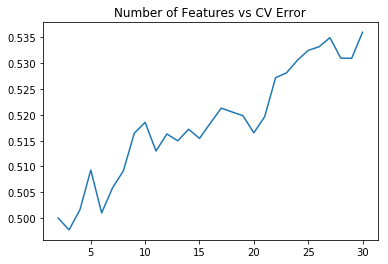

In [17]:
# Random forest
features_rf = list(feature_importances['feature_rf'])
num_of_features_cv_plot(rf, 30, features_rf)

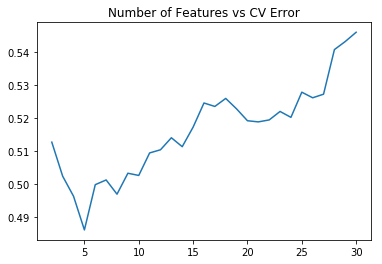

In [18]:
# Gradient Boosting Tree
features_gbt = list(feature_importances['feature_gbt'])
num_of_features_cv_plot(gbt, 30, features_gbt)

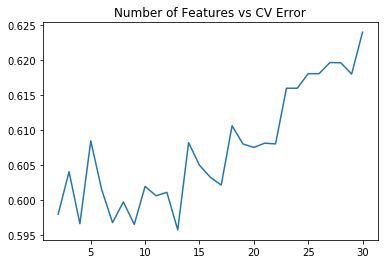

In [19]:
# Xgboost Tree
features_xgb = list(feature_importances['feature_xgb'])
num_of_features_cv_plot(xgb, 30, features_xgb)

### 2. Parameter Tuning

In [20]:
features_rf.extend(['id', 'relevance', 'product_uid'])
features_gbt.extend(['id', 'relevance', 'product_uid'])
features_xgb.extend(['id', 'relevance', 'product_uid'])

In [21]:
df_sub_rf = df_all[features_rf]
df_sub_gbt = df_all[features_gbt]
df_sub_xgb = df_all[features_xgb]

In [22]:
test_ids, rf_y_train, rf_X_train, rf_X_test = generate_train_test_data(features_rf, df_sub_rf)
test_ids, gbt_y_train, gbt_X_train, gbt_X_test = generate_train_test_data(features_gbt, df_sub_gbt)
test_ids, xgb_y_train, xgb_X_train, xgb_X_test = generate_train_test_data(features_xgb, df_sub_xgb)

In [23]:
# base models
rf = RandomForestRegressor(random_state=SEED)
gbt = GradientBoostingRegressor(random_state=SEED)
xgb = XGBRegressor(random_state=SEED)

In [24]:
# Generate hyperparameter dictionary
base_learners = [
    ('rf', rf), ('xgb', xgb), ('gbt', gbt)
]
params = {
    'rf': {'max_depth': randint(3, 10),'n_estimators': randint(50, 150)},
    'xgb': {'max_depth': randint(3, 10), 'n_estimators': randint(50, 150)},
    'gbt': { 'max_depth': randint(3, 10), 'n_estimators': randint(50, 150)}
}

# Add preprocessing
preprocessing = {
    'none':[]
}

In [25]:
# reference: http://ml-ensemble.com/info/tutorials/start.html
# make a scorer
from mlens.metrics import make_scorer
mean_sqaured_error_scorer = make_scorer(mean_squared_error, greater_is_better=True)
# run evaluation
# cv = ShuffleSplit(test_size=0.3, random_state=0)
# cv must be an integer
evaluator = Evaluator(mean_sqaured_error_scorer, cv=5, random_state=0, verbose=1)
evaluator.fit(
              rf_X_train, 
              rf_y_train, 
              estimators = base_learners,\
              param_dicts = params,\
              preprocessing = preprocessing,\
              n_iter=2
             )

Launching job
Job           done | 00:00:02


In [26]:
pd.DataFrame(evaluator.results)

,test_score-m,test_score-s,train_score-m,train_score-s,fit_time-m,fit_time-s,pred_time-m,pred_time-s,params
none.gbt,0.500407,0.112634,9.944964e-08,2.395698e-10,0.555714,0.255872,0.004459,0.007335,"{'max_depth': 8, 'n_estimators': 97}"
none.rf,0.292048,0.093148,4.452817e-02,4.611895e-03,0.944491,0.133098,0.054247,0.044790,"{'max_depth': 7, 'n_estimators': 94}"
none.xgb,0.338171,0.095183,3.667600e-06,1.633578e-06,0.126058,0.017753,0.001762,0.000711,"{'max_depth': 8, 'n_estimators': 97}"


#### 2.3 Choose Meta Learner 

In [27]:
# Tuning?
lr = LinearRegression()

In [28]:
# Compare the performance of xgb and lr
xgb_meta = XGBRegressor(random_state=SEED)
meta_learners = [
    ('xgb_meta', xgb_meta), ('lr', lr)
]
params = {
    'lr':
    {},
    'xgb_meta':
    {
     'max_depth': randint(3, 15),
     'n_estimators': randint(10, 100)
    }
}

In [29]:
in_layer = SuperLearner(model_selection=True)
in_layer.add(base_learners)
preprocess = [in_layer]

In [30]:
evaluator.fit(
    rf_X_train, 
    rf_y_train,
    meta_learners,
    params,
    preprocessing={'meta': preprocess},
    n_iter=4                            
)

Launching job
Job           done | 00:00:31


In [31]:
pd.DataFrame(evaluator.results)

,test_score-m,test_score-s,train_score-m,train_score-s,fit_time-m,fit_time-s,pred_time-m,pred_time-s,params
meta.lr,0.289076,0.091240,0.257876,0.025918,1.720978,0.289673,0.010449,0.010830,{}
meta.xgb_meta,0.420131,0.115123,0.004129,0.000909,2.790536,0.212974,0.011673,0.011752,"{'max_depth': 6, 'n_estimators': 74}"


Based on above result, we select linear regression as the second layer.

In [32]:
meta_learner = lr

#### 2.4 Esemble Learning

In [ ]:
# mean_sqaured_error_scorer = make_scorer(mean_squared_error, greater_is_better=True)
# no need to use make scorer method
ensemble = SuperLearner(scorer=mean_squared_error, random_state=0, verbose=2)
ensemble.add(base_learners)
ensemble.add_meta(meta_learners)
ensemble.fit(rf_X_train, rf_y_train)
pred_ensemble = ensemble.predict(rf_X_test)
pd.DataFrame({"id": test_ids, "relevance": pred_ensemble}).to_csv('submission.csv',index=False)